# Brain Tumor Segmentation (BraTS) with OpenVINO™

In this code example, we apply the U-Net architecture to segment brain tumors from raw MRI scans. With relatively little data we are able to train a U-Net model to accurately predict where tumors exist. 

The Dice coefficient (the standard metric for the BraTS dataset used in the study) for our model is about 0.82-0.88.  Menze et al. [reported](http://ieeexplore.ieee.org/document/6975210/) that expert neuroradiologists manually segmented these tumors with a cross-rater Dice score of 0.75-0.85, meaning that the model’s predictions are on par with what expert physicians have made. The below MRI brain scans highlight brain tumor matter segmented using deep learning. 

<img src="images/figure1.png">

## Demonstration objectives
* Healthcare use-case demo
* **Model Optimizer** in action
* U-Net based segmentation on edge hardware
* Inferencing with OpenVINO™ Inference Engine
* Running inference across CPU, integrated GPU, VPU, and FPGA and comparing throughput and latency

## What is U-Net?
Since its introduction two years ago, the [U-Net](https://arxiv.org/pdf/1505.04597.pdf0) architecture has been used to create deep learning models for segmenting [nerves](https://github.com/jocicmarko/ultrasound-nerve-segmentation) in ultrasound images, [lungs](https://www.kaggle.com/c/data-science-bowl-2017#tutorial) in CT scans, and even [interference](https://github.com/jakeret/tf_unet) in radio telescopes.

U-Net is designed like an [auto-encoder](https://en.wikipedia.org/wiki/Autoencoder). It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?” This flexibility allows U-Net to predict different parts of the tumor simultaneously.

<img src="images/unet.png">

## Step 0: Set Up

### 0.1: Import dependencies

Run the below cells to import dependencies (select the cell and use **Ctrl+enter** to run the cell). 

In [1]:
import sys, os 
import ipywidgets as widgets
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *
from IPython.display import display

Note that the first time you run this notebook this step will take a few minutes, as we will be installing `keras` and `psutil` locally to your instance in the DevCloud.

In [2]:
try: 
    import keras
except:
    print("Keras not installed")
    !{sys.executable} -m pip install keras

Keras not installed
    100% |████████████████████████████████| 378kB 1.8MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/0e/46/ae6773894f7eacf53308086287897ec568eac9768918d913d5b9d366c5db/numpy-1.17.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/26/32b8464df2a97e6dd1b656ed26b2c194606c16fe163c695a992b36c11cdf/six-1.13.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 25.2MB 42kB/s  eta 0:00:01  8% |██▉                             | 2.2MB 27.2MB/s eta 0:00:01    98% |███████████████████████████████▋| 24.9MB 30.8MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/pa

In [2]:
try: 
    import psutil
except:
    print("psutil not installed")
    !{sys.executable} -m pip install psutil

psutil not installed
    100% |████████████████████████████████| 450kB 1.6MB/s eta 0:00:01
  Running setup.py bdist_wheel for psutil ... done
  Stored in directory: /home/u26213/.cache/pip/wheels/33/48/b6/72b7243c5caf65b7d5b460e9fad82b1256992284e870b7db59
Successfully built psutil


## Step 1. Create an Intermediate Representation (IR) Model using the Model Optimizer by Intel

The Model Optimizer creates Intermediate Representation (IR) models that are optimized for different end-point target devices.

### 1.1: Generate FP32 Optimized Model
Now, let's convert the model to the optimized model using the model optimizer. This model works best on most hardware, including CPUs.

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

In [5]:
!python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py \
            --input_model /data/Healthcare_app/data/saved_model_frozen.pb \
            --input_shape=[1,144,144,4] \
            --data_type FP32  \
            --output_dir output/IR_models/FP32  \
            --model_name saved_model

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/data/Healthcare_app/data/saved_model_frozen.pb
	- Path for generated IR: 	/home/u26213/R3_devcloud/iot-devcloud/python/Healthcare/output/IR_models/FP32
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,144,144,4]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with inp

**Note** the above line is a single command line input, which spans 4 lines thanks to the backslash '\\', which is a line continuation character in Bash.

Here, the arguments are:
* --input-model : the original model
* --data_type : Data type to use. One of {FP32, FP16, half, float}
* -o : output directory (If this directory does not exist, it will be created for you.)

This script also supports `-h` that will you can get the full list of arguments.

Running that command will produce two files:
```
output/IR_models/FP32/saved_model.xml
output/IR_models/FP32/saved_model.bin
```
These will be used later in the exercise.

### 1.2: Generate FP16 Optimized Model

We will also be needing the FP16 version of the model for the calculations on the VPU architecture. Run the following command to create it.

In [6]:
!python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py \
            --input_model /data/Healthcare_app/data/saved_model_frozen.pb  \
            --input_shape=[1,144,144,4] \
            --data_type FP16  \
            --output_dir output/IR_models/FP16  \
            --model_name saved_model

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/data/Healthcare_app/data/saved_model_frozen.pb
	- Path for generated IR: 	/home/u26213/R3_devcloud/iot-devcloud/python/Healthcare/output/IR_models/FP16
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,144,144,4]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with inp

In [7]:
%%writefile healthcare_job_openvino.sh

# Prevent error and output files from being saved to DevCloud
#PBS -e /dev/null

cd $PBS_O_WORKDIR
DEVICE=$1
RESULTS=$2

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi

if [ "$DEVICE" = "MYRIAD" ] || [ "$DEVICE" = "HDDL" ]; then
    FP_MODEL="FP16"
else
    FP_MODEL="FP32"
fi

    
# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
python3 healthcare_openvino.py     -d $DEVICE \
                                   -IR output/IR_models/${FP_MODEL}/saved_model \
                                   -l /opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension_avx2.so \
                                   -r $RESULTS

Writing healthcare_job_openvino.sh


## Step 2. Inference Time!

Here we create job files and submit them to different edge compute nodes. They will go into a queue and run once the compute resources are available. 

#### Submitting to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run the CPU.

In [8]:
job_id_core = !qsub healthcare_job_openvino.sh -l nodes=1:kaby-lake -F "CPU results/"
print(job_id_core[0]) 
if job_id_core:
    progressIndicator('results/'+job_id_core[0], 'i_progress.txt', "Processing", 0, 100)

915.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel® 
    Xeon® Processor E3-1268L v5</a>. The inference workload will run on the CPU.

In [9]:
job_id_xeon = !qsub healthcare_job_openvino.sh -l nodes=1:skylake -F "CPU results/"
print(job_id_xeon[0]) 
if job_id_xeon:
    progressIndicator('results/'+job_id_xeon[0], 'i_progress.txt', "Processing", 0, 100)

916.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Core CPU and using the onboard Intel® GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [11]:
#Submit job to the queue
job_id_gpu = !qsub healthcare_job_openvino.sh -l nodes=1:intel-hd-p530 -F "GPU results/"
print(job_id_gpu) 
if job_id_gpu:
    progressIndicator('results/'+job_id_gpu[0], 'i_progress.txt', "Processing", 0, 100)

['918.v-qsvr-1.devcloud-edge']


#### Submitting to an edge compute node with Intel® NCS 2 (Neural Compute Stick 2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [10]:
#Submit job to the queue
job_id_ncs2 = !qsub healthcare_job_openvino.sh -l nodes=1:intel-ncs2 -F "MYRIAD results/"
print(job_id_ncs2[0]) 
if job_id_ncs2:
    progressIndicator('results/'+job_id_ncs2[0], 'i_progress.txt', "Processing", 0, 100)

917.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core™ i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card installed in this node.

In [12]:
job_id_fpga = !qsub healthcare_job_openvino.sh -l nodes=1:hddl-f -F "HETERO:FPGA,CPU results/"
print(job_id_fpga[0]) 
if job_id_fpga:
    progressIndicator('results/'+job_id_fpga[0], 'i_progress.txt', "Processing", 0, 100)

919.v-qsvr-1.devcloud-edge


You can view the status of the jobs below. 

In [ ]:
liveQstat()

## Step 3. Results

### 3.1: Image Comparison
Here, we visualize our predictions. We can observe the frame rate, execution time, and dice coefficient (a value that describes the similarity between the ground truth and the prediction, with 1.0 indicating 100% accuracy). Note that it may take a few seconds to display the results. 

In [13]:
outputHTML('IEI Tank (Intel Core CPU)',
          'results/'+job_id_core[0], '.png')

In [14]:
outputHTML('IEI Tank Xeon (Intel Xeon CPU)',
          'results/'+job_id_xeon[0], '.png')

In [15]:
outputHTML('IEI Intel GPU (Intel Core + Onboard GPU)',
          'results/'+job_id_gpu[0], '.png')

In [17]:
outputHTML('IEI Tank + Intel CPU + Intel NCS2',
          'results/'+job_id_ncs2[0], '.png')

In [16]:
outputHTML('IEI Tank + IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)',
          'results/'+job_id_fpga[0], '.png')

### 3.2: Architecture Comparison

Finally, we benchmark the processing time and frames per second on different architectures.

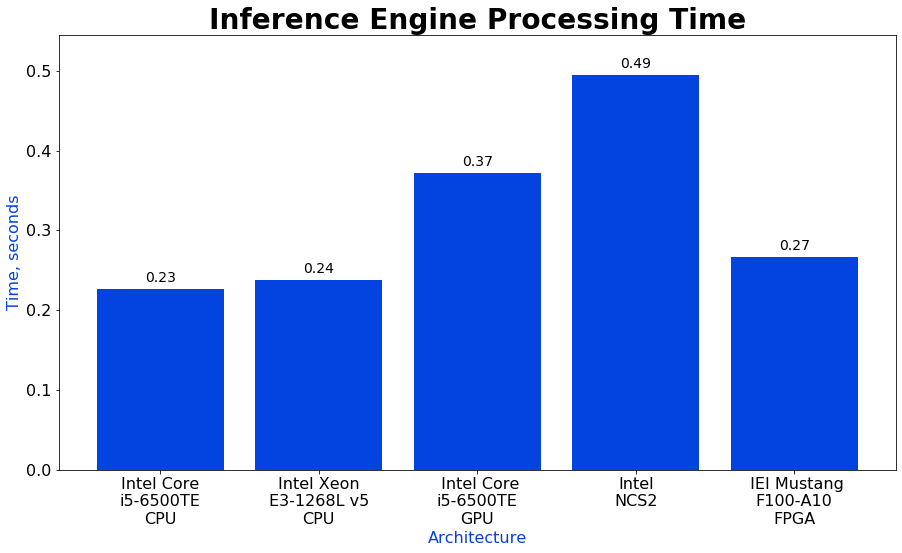

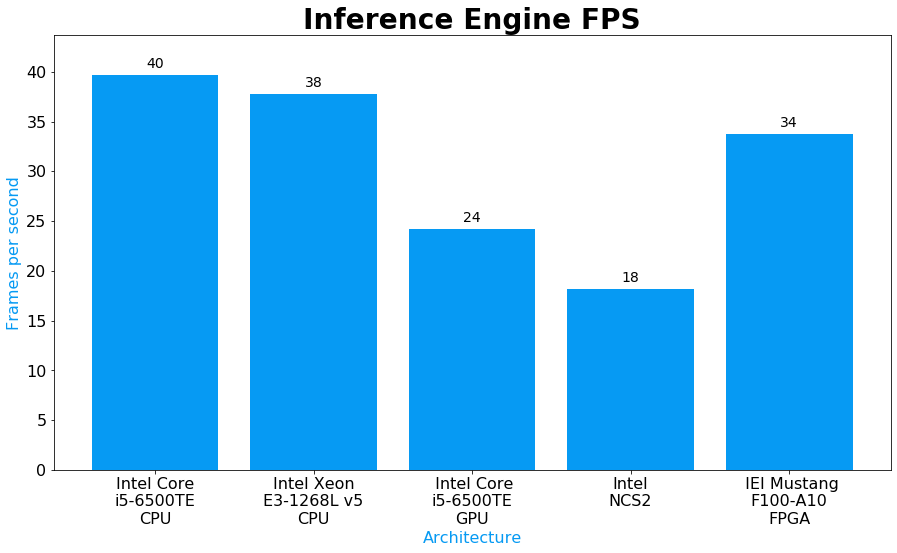

In [18]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('ncs2', 'Intel\nNCS2'),
             ('fpga', ' IEI Mustang\nF100-A10\nFPGA')]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/'+vars()['job_id_'+arch][0]+'/stats.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )